In [1]:
%load_ext autoreload
%autoreload 2

In [87]:
import os
import sys
import glob
import logging

import requests
from tqdm import tqdm,tqdm_notebook

import numpy as np
import pandas as pd

from dvidutils import LabelMapper
from libdvid import DVIDNodeService

from neuclease import configure_default_logging
from neuclease.dvid import *
from neuclease.util import Timer, closest_approach
from neuclease.merge_table import normalize_recarray_inplace, generate_focused_assignment, generate_assignments
from neuclease.focused.ingest import *
from neuclease.focused.scores import calc_speculative_scores
from neuclease.focused.favorites import compute_favorites, mark_favorites, extract_favorites

In [3]:
from DVIDSparkServices.spark_launch_scripts.janelia_lsf.lsf_utils import get_hostgraph_url
print("This notebook:")
print(get_hostgraph_url(os.environ["LSB_JOBID"]))
print("Cluster:")
print(get_hostgraph_url(os.environ["MASTER_BJOB_ID"]))

This notebook:
http://lsf-rtm/cacti/plugins/grid/grid_bjobs.php?action=viewjob&tab=hostgraph&clusterid=1&indexid=0&jobid=45356134&submit_time=1535045542
Cluster:
http://lsf-rtm/cacti/plugins/grid/grid_bjobs.php?action=viewjob&tab=hostgraph&clusterid=1&indexid=0&jobid=45363882&submit_time=1535058895


In [4]:
root_logger = logging.getLogger()
root_logger.handlers = []
configure_default_logging()

In [5]:
pwd

'/nrs/flyem/bergs/complete-ffn-agglo'

In [6]:
sc

<SparkContext master=spark://h05u31:7077 appName=PySparkShell>

### UUIDS

In [7]:
# The starting agglo
initial_agglo_node = ('emdata3:8900', 'ac901')

# # The uuid used when loading the neo4j instance (for 'important bodies')
# neo4j_reference = DvidInstanceInfo('emdata3:8900', '52f9', 'segmentation')

# # The last supervoxel splits: One past the neo4j node
# analysis_node = DvidInstanceInfo('emdata3:8900', '662e', 'segmentation')

# Current master
master_node = ('emdata3:8900', '7254')

### Master mapping

In [8]:
master_mapping = fetch_complete_mappings(*master_node, 'segmentation')

INFO [2018-08-23 17:16:15,604] Reading kafka messages from kafka.int.janelia.org:9092 for emdata3:8900 / 7254 / segmentation
INFO [2018-08-23 17:16:29,833] Reading 518722 kafka messages took 14.22805666923523 seconds
INFO [2018-08-23 17:16:35,744] Fetching http://emdata3:8900/api/node/7254/segmentation/mappings...
INFO [2018-08-23 17:17:11,935] Fetching http://emdata3:8900/api/node/7254/segmentation/mappings took 0:00:36.189828
INFO [2018-08-23 17:17:11,936] Parsing mapping...
INFO [2018-08-23 17:17:20,246] Parsing mapping took 0:00:08.309619
INFO [2018-08-23 17:17:20,251] Constructing missing identity-mappings...
INFO [2018-08-23 17:17:43,633] Constructing missing identity-mappings took 0:00:23.381171


### Previous decisions

In [13]:
LOAD_PREVIOUS_FROM_CSV = True
_path = f'focused-decisions-{master_node[1]}-2018-08-23.csv'

if LOAD_PREVIOUS_FROM_CSV:
    df = pd.read_csv(_path)
    df.fillna(0.0, inplace=True)
    df['sv_a'] = df['sv_a'].astype(np.uint64)
    df['sv_b'] = df['sv_b'].astype(np.uint64)
    df['body_a'] = df['body_a'].astype(np.uint64)
    df['body_b'] = df['body_b'].astype(np.uint64)
    previous_focused_decisions = df
else:
    previous_focused_decisions = fetch_focused_decisions(*master_node, 'segmentation_merged',
                                                         normalize_pairs='sv', show_progress=True)

previous_focused_decisions.to_csv(_path, index=False, header=True)
previous_focused_decisions.rename(inplace=True, columns={'sv_a': 'id_a', 'sv_b': 'id_b'})
print(f"Loaded {len(previous_focused_decisions)} previous decisions")

Loaded 405243 previous decisions


### Important bodies

In [14]:
focused_bodies_path = 'focused-bodies-table-7254.csv'
focused_bodies_table = pd.read_csv(focused_bodies_path, dtype={'body': np.uint64})
focused_bodies_table.set_index('body', inplace=True)
important_bodies = set(focused_bodies_table.index)
print(f"Working with {len(important_bodies)} focused bodies")

Working with 589591 focused bodies


### Load/filter/score 2-hop tables

- load pre-updated tables (coords already fixed, supervoxels updated)
- normalize (`a<b`)
- filter
   - important TWO-HOP
   - non-merged
   - not yet reviewed
     - Note: this will toss out previously reviewed 'favorite' edges, meaning the next 'favorite' we pick below will be e.g. 2nd-favorite (if it survives the threshold).  Is that what we want?
- append scores

In [19]:
os.makedirs(f'twohop-tables-{master_node[1]}/32nm', exist_ok=True)
os.makedirs(f'twohop-tables-{master_node[1]}/16nm', exist_ok=True)
os.makedirs(f'twohop-tables-{master_node[1]}/8nm', exist_ok=True)

previous_sv_values = previous_focused_decisions[['id_a', 'id_b']].values

driver_cwd = os.getcwd()

def apply_mapping_and_filter_to_partition(paths):
    print("init mapping...")
    # Must create mapper here since it cannot be pickled.
    mapper = LabelMapper(master_mapping.index.values, master_mapping.values)

    # Compute once
    print("init sv pairs...")
    previous_sv_pairs = set(map(tuple, previous_sv_values))

    def apply_mapping_and_filter(npy_path):
        """
        Load the table from the given npy file,
        apply the body mapping, and remove rows with matching bodies.
        Also remove rows that correspond to decisions that have already been made.
        
        The resulting filtered table is stored in 'twohop-tables-*/*nm/'
        """
        print("loading table...")
        table = np.load(npy_path)
        df = pd.DataFrame(table)

        print("mapping bodies...")
        # A bug above caused the type to be int64. Fix that now.
        df['id_a'] = df['id_a'].astype(np.uint64, copy=False)
        df['id_b'] = df['id_b'].astype(np.uint64, copy=False)
        
        df['body_a'] = mapper.apply(df['id_a'].values, allow_unmapped=True)
        df['body_b'] = mapper.apply(df['id_b'].values, allow_unmapped=True)

        important_bodies # Referenced to ensure capture in this closure

        print("filtering...")
        # Drop internal edges,
        # Filter for important bodies (on at least one end -- capture 1-hop and 2-hop)
        q = '(body_a != body_b) and ((body_a in @important_bodies) or (body_b in @important_bodies))'
        df.query(q, inplace=True)

        print("normalizing...")
        table = df.to_records(index=False)
        normalize_recarray_inplace(table, 'id_a', 'id_b',
                                  ['id_a', 'body_a', 'xa', 'ya', 'za', 'caa', 'cba', 'da'],
                                  ['id_b', 'body_b', 'xb', 'yb', 'zb', 'cbb', 'cab', 'db'])
        df = pd.DataFrame(table)
        
        # Drop edges that have already been considered.
        print("dropping previous decisions...")
        sv_pairs = list(map(tuple, df[['id_a', 'id_b']].values))
        df['sv_pair'] = sv_pairs
        df = df[~(df['sv_pair'].isin(previous_sv_pairs))]
        del df['sv_pair']
        
        print("scores...")
        df['score'] = calc_speculative_scores(df[['caa', 'cab', 'cba', 'cbb']].to_records(index=False))
        
        print("writing...")
        res = df['resolution'].iloc[0]
        fname = os.path.split(npy_path)[-1]
        output_path = f'{driver_cwd}/twohop-tables-{master_node[1]}/{res}nm/{fname}'
        np.save(output_path, df.to_records(index=False))

        return len(df)
    
    return list(map(apply_mapping_and_filter, paths))

In [60]:
# Test one first
#%time apply_mapping_and_filter_to_partition(['updated-tables/32nm/data-00000-of-00100.npy'])

In [20]:
filtered_totals = {}

for res in [32, 16, 8]:
    with Timer(f"Processing {res}nm..."):
        paths = map(os.path.abspath, glob.glob(f'updated-tables/{res}nm/data-*.npy'))
        filtered_totals[res] = sc.parallelize(paths).mapPartitions(apply_mapping_and_filter_to_partition).sum()
    
print(f"DONE. Total filtered edges: {sum(filtered_totals.values())}")

INFO [2018-08-23 17:32:09,033] Processing 32nm......
INFO [2018-08-23 17:33:27,120] Processing 32nm... took 0:01:18.085101
INFO [2018-08-23 17:33:27,122] Processing 16nm......
INFO [2018-08-23 17:35:13,886] Processing 16nm... took 0:01:46.763498
INFO [2018-08-23 17:35:13,889] Processing 8nm......
INFO [2018-08-23 17:37:19,104] Processing 8nm... took 0:02:05.215029
DONE. Total filtered edges: 906662181


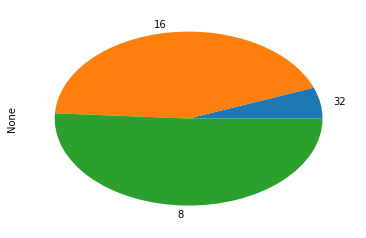

In [37]:
pd.Series(filtered_totals).plot(kind='pie')

### Select 1-hop edges

In [67]:
os.makedirs(f'onehop-tables-{master_node[1]}/32nm', exist_ok=True)
os.makedirs(f'onehop-tables-{master_node[1]}/16nm', exist_ok=True)
os.makedirs(f'onehop-tables-{master_node[1]}/8nm', exist_ok=True)

driver_cwd = os.getcwd()

def select_and_write_onehop(twohop_path):
    important_bodies # ref for pickle

    print("reading...")
    df = pd.DataFrame(np.load(twohop_path))
    res = df['resolution'].iloc[0]
    
    print("filtering...")
    q = 'body_a in @important_bodies and body_b in @important_bodies'
    df.query(q, inplace=True)
    
    print("writing...")
    fname = os.path.split(twohop_path)[-1]
    output_path = f'{driver_cwd}/onehop-tables-{master_node[1]}/{res}nm/{fname}'
    np.save(output_path, df.to_records(index=False))
    return len(df)
    
all_twohop_chunk_paths = map(os.path.abspath, glob.glob('twohop-tables-7254/*nm/*.npy'))
total_onehop_edges = sc.parallelize(all_twohop_chunk_paths).map(select_and_write_onehop).sum()
print(f"Selected {total_onehop_edges} one-hop edges")

Selected 234106600 one-hop edges


### Load into combined table

In [68]:
all_onehop_chunk_paths = glob.glob('onehop-tables-7254/*nm/*.npy')
all_onehop_chunks = list(map(np.load, tqdm_notebook(all_onehop_chunk_paths)))
combined_onehop_table = np.concatenate(all_onehop_chunks)
del all_onehop_chunks
print(f"Combined table is {combined_onehop_table.nbytes / 1e9:.1f} GB")

HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Combined table is 20.8 GB


In [69]:
%time combined_onehop_df = pd.DataFrame(combined_onehop_table)

CPU times: user 55.7 s, sys: 16.9 s, total: 1min 12s
Wall time: 53.5 s


In [70]:
combined_onehop_df.head()

,id_a,id_b,xa,ya,za,xb,yb,zb,caa,cab,cba,cbb,iou,da,db,resolution,body_a,body_b,score
0,1012359606,1135833306,16448,23743,15961,16401,23783,15924,0.982629,0.000000,0.001461,0.992530,0.000019,0.002408,0.000507,8,5813039957,1135828787,0.001461
1,1016749434,1016753364,10412,30574,14398,10406,30626,14399,0.986544,0.000000,0.000000,0.947968,0.000000,0.001237,0.002138,8,1016749259,1016758041,0.000000
2,1049662264,1049662419,27573,32595,14852,27513,32615,14878,0.991906,0.002317,0.000069,0.918828,0.000000,0.002363,0.003926,8,613175370,5813049530,0.002317
3,1075054375,1167852620,12425,24956,16373,12436,24992,16339,0.777855,0.000000,0.000000,0.970840,0.000000,0.009229,0.000394,8,890191637,823058891,0.000000
4,1097365311,1097706148,23432,14451,15693,23444,14463,15684,0.994048,0.000359,0.000000,0.905296,0.000000,0.000107,0.000662,8,5813040784,973566036,0.000359


In [71]:
### Discard unneeded columns
%time combined_onehop_df = combined_onehop_df[['id_a', 'id_b', 'body_a', 'body_b', 'score', 'xa', 'ya', 'za', 'xb', 'yb', 'zb']].copy()

CPU times: user 25.2 s, sys: 17.1 s, total: 42.3 s
Wall time: 5.11 s


In [75]:
combined_onehop_df.memory_usage().sum() / 1e9

14.046396079999999

### Pre-threshold by score

Thresholded table has 2.1M rows (0.1 GB)


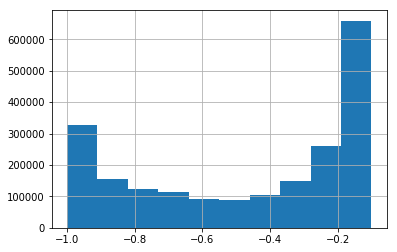

In [81]:
thresholded_df = combined_onehop_df[combined_onehop_df['score'] >= 0.1].copy()

_rows = len(thresholded_df)
_nbytes = thresholded_table.memory_usage().sum()
print(f"Thresholded table has {_rows/1e6:.1f}M rows ({_nbytes/1e9:.1f} GB)")

# Michal's scores use "higher is better",
# but compute_favorites() assumes "lower is better"
thresholded_df['score'] *= -1
thresholded_df['score'].hist()

### Choose favorites

In [82]:
%%time
body_favorites = compute_favorites(thresholded_df)
print(f"Found {len(body_favorites)} favorites")

Found 317314 favorites
CPU times: user 1min 24s, sys: 8.4 s, total: 1min 32s
Wall time: 1min 9s


In [83]:
%%time
favorite_flags_df = mark_favorites(thresholded_df, body_favorites)
favorite_onehop_df = extract_favorites(thresholded_df, favorite_flags_df, only_mutual=False)

CPU times: user 8.06 s, sys: 2.42 s, total: 10.5 s
Wall time: 812 ms


In [85]:
favorite_onehop_df = favorite_onehop_df[['id_a','id_b','body_a','body_b','xa','ya','za','xb','yb','zb','score']]
favorite_onehop_df.to_csv('remaining-onehop-assignments-7254-20180823.csv', index=False)

In [94]:
favorite_onehop_df.shape

(264610, 11)

### Generate assignments

In [90]:
generate_assignments(favorite_onehop_df, 10_000, 'remaining-onehop-assignments-7254-20180823')

100%|██████████| 26/26 [00:08<00:00,  3.02it/s]


In [92]:
# sample assignment
np.random.seed(0)
_choices = np.random.choice(favorite_onehop_df.index, size=(100,), replace=False)
_ = generate_focused_assignment(favorite_onehop_df.loc[_choices],
                                'remaining-onehop-assignments-7254-20180823-SAMPLE-ASSIGNMENT.json')